## Waitnoise

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8-whitegrid")
np.random.seed(42)

In [71]:
pd.set_option("display.precision", 4)
pd.set_option("display.float_format", lambda x: f"{x:,.4f}")
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 10)

df.style.set_table_styles([
    {"selector": "thead th",
     "props": [("background-color", "#f2f2f2"),
               ("font-weight", "bold"),
               ("border-bottom", "1px solid #999")]},
    {"selector": "tbody td",
     "props": [("border", "0px")]}
]).format("{:,.4f}")

,price
t,
0,100.4967
1,100.3578
2,101.0078
3,102.5461
4,102.3060
5,102.0665
6,103.6783
7,104.4740
8,103.9835


In [64]:
def generate_white_noise_prices(n=500, S0=100, vol=0.01):
    returns = np.random.normal(0, vol, n)
    prices = S0 * np.cumprod(1 + returns)
    df = pd.DataFrame({"price": prices})
    df.index.name = "t"
    return df

df = generate_white_noise_prices()
df.head()

,price
t,
0,100.4967
1,100.3578
2,101.0078
3,102.5461
4,102.3060


In [65]:
def buy_and_hold(df):
    return pd.Series(1, index=df.index)

def simple_momentum(df):
    sig = np.sign(df["price"].diff())
    sig.iloc[0] = 0
    return sig

def mean_reversion(df, window=5):
    ma = df["price"].rolling(window).mean()
    sig = -np.sign(df["price"] - ma)
    sig.fillna(0, inplace=True)
    return sig

In [66]:
def backtest(df, signal, initial_capital=1_000_000, trade_size=1000):
    df = df.copy()
    df["signal"] = signal
    cash = initial_capital
    position = 0

    equity_list = []
    cash_list = []
    pos_list = []

    for t in df.index:
        price_t = df.loc[t, "price"]
        sig_t = df.loc[t, "signal"]
        target_position = sig_t * trade_size
        trade = target_position - position

        cash -= trade * price_t
        position = target_position
        equity = cash + position * price_t

        cash_list.append(cash)
        pos_list.append(position)
        equity_list.append(equity)

    df["cash"] = cash_list
    df["position"] = pos_list
    df["equity"] = equity_list
    return df

In [67]:
strategies = {
    "Buy & Hold": buy_and_hold,
    "Momentum": simple_momentum,
    "Mean Reversion": mean_reversion,
}

results = {}

for name, strat_func in strategies.items():
    sig = strat_func(df)
    results[name] = backtest(df, sig)


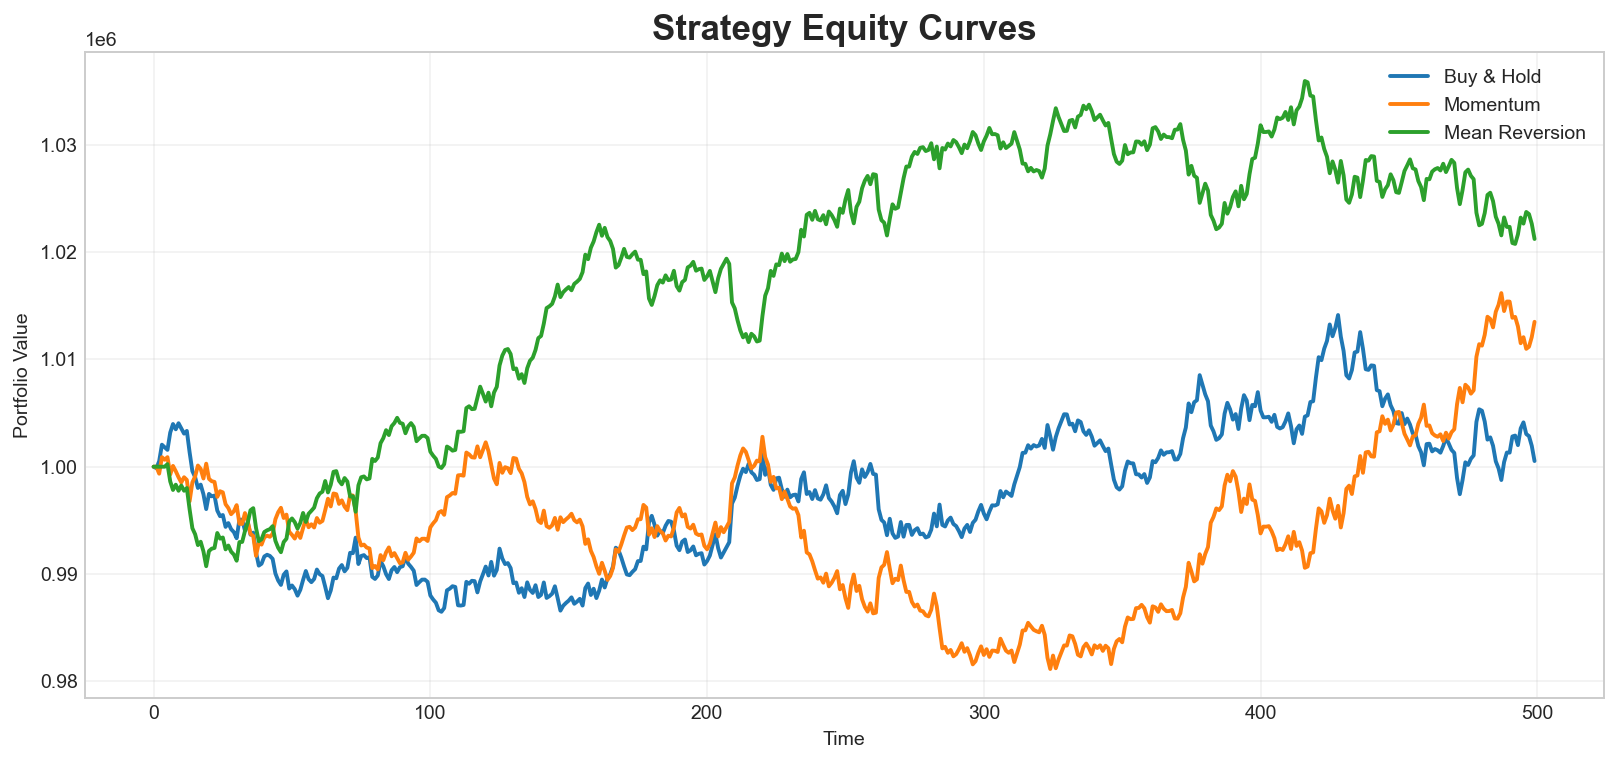

In [68]:
plt.figure(figsize=(14, 6), dpi=140)

for name, res in results.items():
    plt.plot(res.index, res["equity"], linewidth=2, label=name)

plt.title("Strategy Equity Curves", fontsize=18, weight="bold")
plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [69]:
summary = pd.DataFrame({
    name: {
        "Final Equity": res["equity"].iloc[-1],
        "Return %": (res["equity"].iloc[-1] / res["equity"].iloc[0] - 1) * 100,
        "Max Drawdown": (res["equity"].cummax() - res["equity"]).max(),
        "Sharpe (rough)": res["equity"].pct_change().mean() / res["equity"].pct_change().std()
    }
    for name, res in results.items()
}).T

summary

,Final Equity,Return %,Max Drawdown,Sharpe (rough)
Buy & Hold,"1,000,527.8226",0.0528,"17,574.3871",0.0016
Momentum,"1,013,504.0024",1.3504,"21,644.9965",0.0282
Mean Reversion,"1,021,225.0932",2.1225,"15,182.7224",0.0450
